In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

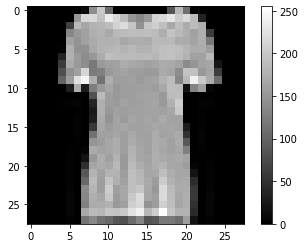

In [5]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [6]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

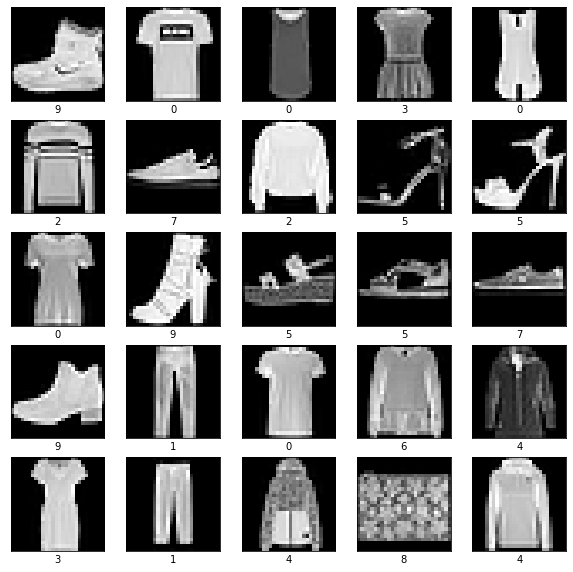

In [7]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

### Categorias para trabajar

In [8]:
np.random.seed(0)
categorias = np.random.randint(10, size = 3)
categorias

array([5, 0, 3])

#### Creando diccionario

In [9]:
diccionario = {5 : "Sandal", 0 : "T-shirt/top", 3 : "Dress"}

### Seleccionando categorias

In [10]:
#indices
i_train = np.where((train_labels == categorias[0])|(train_labels == categorias[1])|(train_labels == categorias[2]))
i_test = np.where((test_labels == categorias[0])|(test_labels == categorias[1])|(test_labels == categorias[2]))
#resize
r_train_images = np.copy(train_images[i_train])
r_train_images = r_train_images.reshape((r_train_images.shape[0], r_train_images.shape[1]*r_train_images.shape[2]))
r_test_images = np.copy(test_images[i_test])
r_test_images = r_test_images.reshape((r_test_images.shape[0], r_test_images.shape[1]*r_test_images.shape[2]))

print(r_train_images.shape)
print(r_test_images.shape)

(18000, 784)
(3000, 784)


#### One hot encoding

In [11]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labels = categorias
categorias = labelencoder.fit_transform(train_labels[i_train])
train_y = np.eye(len(set(train_labels[i_train])))[categorias]

labels = categorias
categorias = labelencoder.fit_transform(test_labels[i_test])
test_y = np.eye(len(set(test_labels[i_test])))[categorias]

num_test = test_y.shape[0]

print(train_y.shape)
print(test_y.shape)

(18000, 3)
(3000, 3)


#### Grafo

In [13]:
tf.reset_default_graph()
grafo = tf.Graph()
with grafo.as_default() as g:
    X = tf.placeholder("float", (None, r_train_images.shape[1]), name = "X_train")
    Y = tf.placeholder("float", (None, train_y.shape[1]), name = "Y_train")
    W = tf.Variable(tf.zeros([r_train_images.shape[1], train_y.shape[1]]), name = "W", dtype = "float")
    b = tf.Variable(tf.zeros([train_y.shape[1]]), name = "b", dtype = "float")
    lr = tf.placeholder("float", name = "learning_rate")
    with tf.name_scope('Mult') as scope:
        mul = tf.matmul(X, W) + b
    with tf.name_scope('Softmax') as scope:
        soft = tf.nn.softmax(mul, name = "Softmax")
    with tf.name_scope('Entropia_Cruzada') as scope:
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = soft))
        cost_summary = tf.summary.scalar("cost", cost)
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    with tf.name_scope("Prediccion") as scope:
        pred = tf.equal(tf.argmax(soft,1), tf.argmax(Y,1))
    with tf.name_scope("Accuracy") as scope:
        accuracy = tf.reduce_mean(tf.cast(pred, "float"))
        accuracy_summary = tf.summary.scalar('Accuracy', accuracy)
    group_summ = tf.summary.merge_all()
    init = tf.global_variables_initializer()

In [20]:
def regresion_logistica(data_x, data_y, l_r, t_epoch, batch_size, display_epoch, name):
    num_train = data_y.shape[0]
    t_batch = num_train//batch_size
        
    with tf.Session(graph = grafo) as sess:
        writer = tf.summary.FileWriter("./graphs/lr_"+str(l_r)+"_"+name, sess.graph)
        sess.run(init)
        for epoch in range(t_epoch):
            resultado_costo = 0
            for bt in range(t_batch):
                batch_x = data_x[bt*batch_size:bt*batch_size+batch_size]
                batch_y = data_y[bt*batch_size:bt*batch_size+batch_size]
                sess.run(optimizer, feed_dict = {X: batch_x, Y: batch_y, lr: l_r})
            if (epoch + 1) % 10 == 0:
                training_cost, weight, bias, acc = sess.run([cost, W, b, accuracy], feed_dict = {X: batch_x, Y: batch_y, lr: l_r})
                s = sess.run(group_summ, feed_dict = {X: batch_x, Y: batch_y, lr: l_r})
                writer.add_summary(s, epoch+1)
            if (epoch + 1) % display_epoch == 0:
                training_cost, weight, bias, acc = sess.run([cost, W, b, accuracy], feed_dict = {X: batch_x, Y: batch_y, lr: l_r})
                s = sess.run(group_summ, feed_dict = {X: batch_x, Y: batch_y, lr: l_r})
                print("Epoch: ", (epoch + 1), "Costo: ", training_cost, "W: ", weight, "b: ", bias, "Accuracy: ", acc)
                print("----------------------------------------------")
        writer.close()
        return [weight, bias]

In [21]:
resultado = []
learning_rates = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

In [22]:
for num, lrate in enumerate(learning_rates):
    resultado.append(regresion_logistica(r_train_images, train_y, lrate, 100, 32, 100, "sin_normalizar"))

Epoch:  100 Costo:  0.61394465 W:  [[ 4.3229240e-05 -4.3229338e-05  0.0000000e+00]
 [ 4.3374184e-05 -4.3374028e-05 -2.6172323e-10]
 [ 1.9752869e-04 -1.5001619e-04 -4.7512305e-05]
 ...
 [-1.6045425e-02 -2.1522712e-04  1.6260659e-02]
 [-3.2140783e-03 -1.9960273e-02  2.3174366e-02]
 [-1.5235267e-04  1.3824657e-04  1.4106515e-05]] b:  [-0.00132573 -0.00160095  0.00292668] Accuracy:  0.9375
----------------------------------------------
Epoch:  100 Costo:  0.6139566 W:  [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 6.4210911e-07 -6.4211184e-07 -9.7734601e-20]
 [ 4.7408845e-04  2.4567111e-05 -4.9865543e-04]
 ...
 [-3.4588652e-03  2.9427334e-05  3.4294378e-03]
 [-1.2424557e-03 -2.1161572e-03  3.3586121e-03]
 [ 8.6083958e-07 -8.8434199e-06  7.9827196e-06]] b:  [-0.0004569  -0.00011329  0.00057019] Accuracy:  0.9375
----------------------------------------------
Epoch:  100 Costo:  0.6452085 W:  [[-6.5860156e-12  5.9603641e-12 -2.2854889e-18]
 [ 8.6899075e-07 -8.6845404e-07 -5.3815530e-10]

In [23]:
resultado_normalizado = []

In [24]:
for num, lrate in enumerate(learning_rates):
    resultado_normalizado.append(regresion_logistica(r_train_images/255, train_y, lrate, 100, 32, 100, "normalizada"))

Epoch:  100 Costo:  0.64177346 W:  [[-2.9291416e-06  5.5293026e-06 -2.6001512e-06]
 [ 4.7884852e-05 -3.5531291e-05 -1.2353714e-05]
 [ 1.0822784e-03 -7.7425508e-04 -3.0803413e-04]
 ...
 [-1.8671803e-02 -1.1278145e-02  2.9950427e-02]
 [-9.8958220e-03 -1.0131070e-02  2.0027107e-02]
 [-4.7836505e-04 -3.8143518e-04  8.5980078e-04]] b:  [-0.38649702 -0.26584893  0.652339  ] Accuracy:  0.90625
----------------------------------------------
Epoch:  100 Costo:  0.6583693 W:  [[-2.7433962e-06  4.6359637e-06 -1.8925670e-06]
 [ 1.6342912e-05 -9.2205728e-06 -7.1223694e-06]
 [ 3.1849754e-04 -1.7934061e-04 -1.3915496e-04]
 ...
 [-8.6629046e-03 -5.4464350e-03  1.4109568e-02]
 [-4.1943849e-03 -3.1171422e-03  7.3116096e-03]
 [-1.9105156e-04 -1.0636263e-04  2.9741408e-04]] b:  [-0.15016381 -0.14808935  0.29825214] Accuracy:  0.9375
----------------------------------------------
Epoch:  100 Costo:  0.70832634 W:  [[-1.3484345e-06  2.4272315e-06 -1.0787968e-06]
 [ 7.1863892e-06 -3.4662596e-06 -3.7201376e-0

![Grafo](grafo.png)

![Accuracy](accuracy.png)

![Costo](costo.png)

### Predicciones

In [53]:
t_images = test_images[i_test]
t_labels = test_labels[i_test]

def prediccion(ww, bb, data_x, num_imagen):
    categorias = ["0 - T-shirt/top", "3 - Dress", "5 - Sandal"]
    mul = np.matmul(data_x[num_imagen], ww)+bb
    soft = np.exp(mul-np.max(mul))/np.sum(np.exp(mul-np.max(mul)))
    categoria = np.argmax(soft)
    print("Categoria: ", categorias[categoria])
    print("Probabilidad: ", soft[categoria])

### Data sin normalizar

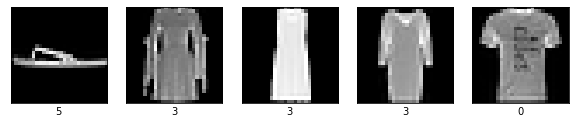

In [54]:
random = np.random.randint(low = 0, high = r_test_images.shape[0], size = 5)
plt.figure(figsize=(10,10))
for i in range(len(random)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(t_images[random[i]], cmap='gray')
    plt.xlabel(t_labels[random[i]])
plt.show()

In [55]:
lr_0_00001 = np.array(resultado[3])
print(lr_0_00001[0].shape)

(784, 3)


In [56]:
for x in random:
    prediccion(lr_0_00001[0], lr_0_00001[1], r_test_images, x)

Categoria:  5 - Sandal
Probabilidad:  0.9999622
Categoria:  3 - Dress
Probabilidad:  0.99999964
Categoria:  3 - Dress
Probabilidad:  1.0
Categoria:  3 - Dress
Probabilidad:  0.99998903
Categoria:  0 - T-shirt/top
Probabilidad:  1.0


### Data normalizada

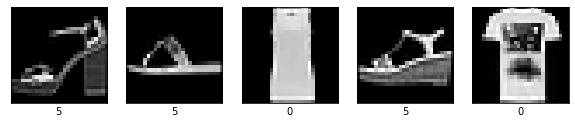

In [57]:
random = np.random.randint(low = 0, high = r_test_images.shape[0], size = 5)
plt.figure(figsize=(10,10))
for i in range(len(random)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(t_images[random[i]], cmap='gray')
    plt.xlabel(t_labels[random[i]])
plt.show()

In [58]:
for x in random:
    prediccion(lr_0_00001[0], lr_0_00001[1], r_test_images/255, x)

Categoria:  5 - Sandal
Probabilidad:  0.34927379426223976
Categoria:  5 - Sandal
Probabilidad:  0.3507818421052098
Categoria:  3 - Dress
Probabilidad:  0.34818151651670026
Categoria:  5 - Sandal
Probabilidad:  0.3562850963487731
Categoria:  0 - T-shirt/top
Probabilidad:  0.3712042403060814
